In [1]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import parse_correlations_dataframe as get_corr
import copy
import get_correlations
import cptac.utils as ut
import matplotlib.patches as mpatches


In [2]:
brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-0467c23f8dc0>, line 9)


In [3]:
def get_original_corr(tissue, gene):
    original_corr = 0
    df_real_corr = pd.read_csv("data/correlations_dataframe.csv")
    for index, value in enumerate(df_real_corr["Cancer_Type"]):
        if value == tissue:
            if (df_real_corr.loc[index]["Gene"] == gene and df_real_corr.loc[index]["Tissue_Type"] == "tumor"):
                original_corr = df_real_corr.loc[index]["Correlation"]
    return original_corr


In [10]:
def get_normal_vs_tumor_plot_and_delta_corr(tissue, gene):
    df_normal = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene}, levels_to_drop=["Database_ID"], tissue_type= "normal")
    df_tumor = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene},levels_to_drop=["Database_ID"], tissue_type="tumor")
    fig = sns.regplot(y = df_tumor[gene+"_proteomics"], x = df_tumor[gene+"_transcriptomics"])
    fig = sns.regplot(y = df_normal[gene+"_proteomics"], x = df_normal[gene+"_transcriptomics"])
    fig.set(xlabel='RNA Abundance', ylabel='Protein Abundance')
    #plt.savefig('Figures/Figure 8a')
    plt.show()
    df_normal = df_normal.dropna()
    df_tumor = df_tumor.dropna()
    corr_normal,pval_normal = scipy.stats.pearsonr(df_normal[gene+"_proteomics"], df_normal[gene+"_transcriptomics"])
    corr_tumor, pval_tumor = scipy.stats.pearsonr(df_tumor[gene+"_proteomics"], df_tumor[gene+"_transcriptomics"])
    delta_corr =  corr_tumor - corr_normal
    return delta_corr

In [11]:
def create_dataframe_with_labels(tissue, gene, clinical_stage):
    df = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene, "clinical" : clinical_stage}, levels_to_drop=["Database_ID"])
    for i, j in enumerate(df[clinical_stage]):
        if (type(j) == str):
            df[clinical_stage][i] = "cancer"
        elif(math.isnan(j)):
            df[clinical_stage][i] = "healthy"
        else:
            df[clinical_stage][i] = "cancer"

    df = df[list(df.columns[:3])]
    df = df.dropna()
    return df



In [12]:
def permute_and_plot_histogram(df,original_correlation, label_1, label_2, permutation_times, gene, clinical_stage, original_delta_corr):
    permutation_list = []
    permu_df = copy.deepcopy(df)
    plot_list = []
    count = 0
    for i in range(permutation_times):
        permu_df[clinical_stage] = np.random.permutation(permu_df[clinical_stage])
        permu_is_label_1 = permu_df[clinical_stage] == label_1
        permu_is_label_2 = permu_df[clinical_stage] == label_2
        label_1_correlation,label_1_pval = scipy.stats.pearsonr(permu_df[permu_is_label_1][gene+"_proteomics"], permu_df[permu_is_label_1][gene+"_transcriptomics"])
        label_2_correlation,label_2_pval = scipy.stats.pearsonr(permu_df[permu_is_label_2][gene+"_proteomics"], permu_df[permu_is_label_2][gene+"_transcriptomics"])
        delta = label_1_correlation - label_2_correlation
        permutation_list.append(delta)
        if (count < 4):
            plot_list.append([permu_df, permu_is_label_1, permu_is_label_2])
            count += 1
    maxx = (max(sns.distplot(permutation_list, color = "grey").get_lines()[0].get_data()[1]))
    plt.plot([original_delta_corr, original_delta_corr], [0, maxx], color = "red")
    red_patch = mpatches.Patch(color='red', label='Original Delta Correlation')
    grey_patch = mpatches.Patch(color='grey', label='Distribution of Permuted Delta Correlations')
    plt.ylim([0,maxx+.7])
    plt.legend(handles=[red_patch,grey_patch])
    plt.savefig('Figures/Figure 8c.png')
    plt.show()
    
    z_score = (original_correlation - np.mean(permutation_list)) / np.std(permutation_list)
    p_val = scipy.stats.norm.sf(abs(z_score))*2
    return p_val, plot_list

In [13]:
def create_df_to_plot_2x5_permutations(list_of_permutated_df,gene):
    x_list = []
    y_list = []
    hue_list = []
    col_list = []
    for index, i in enumerate(list_of_permutated_df):
        tmp_df = i[0]
        tmp_vool = i[1]
        for i in tmp_vool:
            if (i == True):
                hue_list.append("Cancer")
            else:
                hue_list.append("Healthy")
            col_list.append(str(index))
        for i in tmp_df[gene+"_proteomics"]:
            x_list.append(i)
        for i in tmp_df[gene+"_transcriptomics"]:
            y_list.append(i)
    plot_df = pd.DataFrame({"Protein Abundance" : x_list, "RNA Abundance" : y_list, "Tissue_type" : hue_list, "Random_DF_number" : col_list})
    return plot_df

In [14]:
def create_2x5_plot(plot_df):
    sns.lmplot(y="Protein Abundance", x="RNA Abundance", hue="Tissue_type", col="Random_DF_number", data=plot_df, col_wrap = 2,);
    plt.savefig('Figures/Figure 8b.png')
    plt.show()


# Permutation Plots Notebook

Notebook to create 3 plots for a single gene in a single tissue. Plots a scatterplot of normal and tumor, plots 10 scatterplots in a single 2x5 image of permutated data, and a distribution plot showing all delta correlations vs the original delta correlation

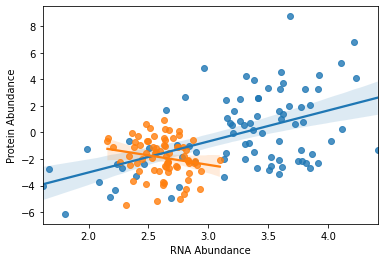

<Figure size 432x288 with 0 Axes>

<ipython-input-11-7cbe7add5321>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clinical_stage][i] = "cancer"
<ipython-input-11-7cbe7add5321>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clinical_stage][i] = "healthy"


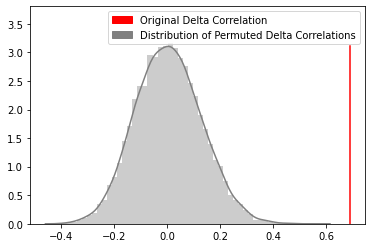

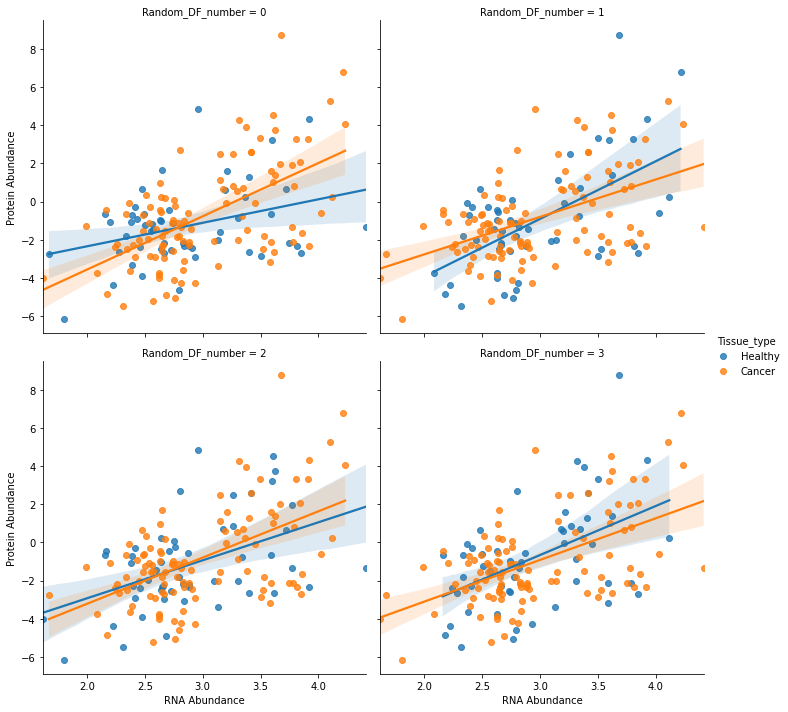

In [15]:
original_corr = get_original_corr("LUAD", "TP53")

original_delta_corr = get_normal_vs_tumor_plot_and_delta_corr(luad,"TP53")
plt.savefig('Figures/Figure 8a.png')
plt.show()

df_with_labels = create_dataframe_with_labels(luad, "TP53", "Stage")

pvaltest, list_of_permutated_df = permute_and_plot_histogram(df_with_labels, original_corr, "cancer", "healthy", 10000, "TP53", "Stage", original_delta_corr)

plot_df = create_df_to_plot_2x5_permutations(list_of_permutated_df, "TP53")

create_2x5_plot(plot_df)
